# Neural network from scratch

Based on YSDA Deep Learning course materials.

https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework01/homework_modules.ipynb

We will implement most common layers using `numpy` for matrix operations. 

The file `modules.py` contains the abstract classes for **module**, **criterion** and **sequential** model class.

**Module** is an abstract class which defines the fundamental methods required for training a neural network.

**Criterion** class implements a container which can be used to score the models answers. 

**Sequential** class implements a container which processes `input` data sequentially. 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython import display

We will implement most common layers using `numpy` for matrix operations. In file `modules.py` are presented the abstract classes for layer, criterion and sequential model class.

The architecture, naming and API are inspired py PyTorch implementation, which will be used in this course further. 

Please, __do not__ change the classes/functions signatures.

#### Some comments
Original `numpy` operation are more preferable than overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They show more expectable memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

In [4]:
from modules import Criterion, Module, Sequential

Before we begin: a [great playground](https://playground.tensorflow.org) to look at.

Try to implement main layers in numpy. Today we stop only on most common ones.

Good read on [Vector, Matrix and Tensor derivatives](http://cs231n.stanford.edu/vecDerivs.pdf)

[Post about einsum](https://habr.com/ru/post/544498/)

[Backpropagation for a Linear Layer handout](http://cs231n.stanford.edu/handouts/linear-backprop.pdf)

## Layers

### Linear transform layer

In [5]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        self.output = np.zeros(shape=(_input.shape[0], self.W.shape[0]))
        np.add(np.dot(_input, np.transpose(self.W)), self.b, out=self.output)
        
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.zeros_like(_input)
        self.gradInput = np.dot(gradOutput, self.W)
        
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        self.gradW += np.dot(np.transpose(gradOutput), _input)
        self.gradb += np.sum(gradOutput, axis=0).ravel()
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [6]:
# testing
def test_linear():
    f_in = 2; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    weight = np.random.normal(size=(f_out, f_in))
    bias = np.random.normal(size=(f_out,))
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_linear = Linear(n_in=f_in, n_out=f_out)
    custom_linear.W = weight
    custom_linear.b = bias
    torch_linear = torch.nn.Linear(in_features=f_in, 
                                   out_features=f_out, 
                                   bias=True, 
                                   dtype=X_tensor.dtype)
    torch_linear.weight.data = torch.tensor(weight)
    torch_linear.bias.data = torch.tensor(bias)
    
    # forward
    Y_custom = custom_linear.forward(X)
    Y_torch = torch_linear(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_linear.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
    assert np.allclose(custom_linear.gradW, torch_linear.weight.grad)
    assert np.allclose(custom_linear.gradb, torch_linear.bias.grad)
    
test_linear()

### SoftMax function

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

[Notes on softmax](https://deepnotes.io/softmax-crossentropy)

In [7]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        
        self.output = np.divide(np.exp(self.output).T, np.sum(np.exp(self.output), axis=1)).T
                
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        gradient = np.einsum("mn,mt->mnt", self.output, self.output)
        self.gradInput = gradOutput * self.output - np.einsum("bm,bmk->bk", gradOutput, gradient)
        
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

In [8]:
# testing
def test_softmax():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_softmax = SoftMax()
    torch_softmax = torch.nn.Softmax(dim=1)
    
    # forward
    Y_custom = custom_softmax.forward(X)
    Y_torch = torch_softmax(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_softmax.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_softmax()

### LogSoftMax function


$logsoftmax(x)_i = log  softmax(x)_i = x_i - log \sum_i exp (x_j) $

In [10]:
class LogSoftMax(Module):
    def __init__(self):
        super(LogSoftMax, self).__init__()
        self.exp_inp = None
        self.exp_inp_sum = None

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        self.exp_inp = np.exp(input)
        self.exp_inp_sum = np.sum(self.exp_inp, axis=1)
        self.output = (input.T - np.log(self.exp_inp_sum)).T
        return self.output

    def updateGradInput(self, input, gradOutput):
        one_grad = (self.exp_inp.T / self.exp_inp_sum).T
        gradient = np.einsum("ij,k->ikj", one_grad, np.ones(self.exp_inp.shape[1]))
        self.gradInput = gradOutput - np.einsum("bm,bmk->bk", gradOutput, gradient)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

In [11]:
# testing
def test_logsoftmax():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_softmax = LogSoftMax()
    torch_softmax = torch.nn.LogSoftmax(dim=1)
    
    # forward
    Y_custom = custom_softmax.forward(X)
    Y_torch = torch_softmax(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_softmax.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_logsoftmax()

### ReLU

In [12]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [13]:
# testing
def test_relu():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_relu = ReLU()
    torch_relu = torch.nn.ReLU()
    
    # forward
    Y_custom = custom_relu.forward(X)
    Y_torch = torch_relu(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_relu.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_relu()

### LeakyReLU

In [14]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.01):
        super(LeakyReLU, self).__init__()
        self.slope = slope
        
    def updateOutput(self, _input):
        self.output = np.copy(_input)
        self.output[self.output < 0] *= self.slope
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.ones(shape=_input.shape)
        self.gradInput[self.output < 0] = self.slope
        np.multiply(self.gradInput, gradOutput, out=self.gradInput)
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

In [15]:
# testing
def test_leakyrelu():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_leakyrelu = LeakyReLU()
    torch_leakyrelu = torch.nn.LeakyReLU()
    
    # forward
    Y_custom = custom_leakyrelu.forward(X)
    Y_torch = torch_leakyrelu(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_leakyrelu.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_leakyrelu()

### ELU

In [16]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def updateOutput(self, input):
        self.output = np.minimum(0, (np.exp(input) - 1) * self.alpha) + np.maximum(0, input) 
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = self.alpha * np.exp(input) * np.multiply(gradOutput, input < 0) +\
                         np.multiply(gradOutput, input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ELU"

In [17]:
# testing
def test_elu():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_elu = ELU()
    torch_elu = torch.nn.ELU()
    
    # forward
    Y_custom = custom_elu.forward(X)
    Y_torch = torch_elu(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_elu.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_elu()

### SoftPlus

In [18]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.log(np.exp(input) + 1)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, 1 / (np.exp(-input) + 1))
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"

In [19]:
# testing
def test_softplus():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    gradient = np.random.normal(size=(n, f_out))
    gradient_tensor = torch.tensor(gradient)
    
    custom_softplus = SoftPlus()
    torch_softplus = torch.nn.Softplus(beta=1.0, threshold=20.0)
    
    # forward
    Y_custom = custom_softplus.forward(X)
    Y_torch = torch_softplus(X_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_softplus.backward(X, gradient)
    Y_torch.backward(gradient_tensor)
    assert np.allclose(gradX_custom, X_tensor.grad)
test_softplus()

## Normalization layers

### Batch Normalization

One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance: 
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance. 

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.


In [17]:
class BatchNormalization(Module):
    EPS = 1e-3

    def __init__(self, alpha=0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = 0
        self.moving_variance = 0

    def updateOutput(self, input):
        if not self.training:
            self.batch_mean = self.moving_mean
            self.batch_variance = self.moving_variance
        else:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_variance = np.var(input, axis=0)
            self.moving_mean = self.moving_mean * self.alpha + self.batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.batch_variance * (1 - self.alpha)

        self.batch_variance += self.EPS
        np.sqrt(self.batch_variance, out = self.batch_variance)
        np.reciprocal(self.batch_variance, out = self.batch_variance)
        self.output = (input - self.batch_mean) * (self.batch_variance)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = input.shape[0] * gradOutput - np.sum(gradOutput, axis=0)
        self.gradInput -= self.output * np.sum(gradOutput * self.output, axis=0)
        self.gradInput *=  (self.batch_variance) / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

Practical notes.  
If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

### Channel-wise scaling

In [21]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = gamma * x + beta
       where gamma, beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

### Dropout

Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [22]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        if not self.training:
            self.mask = np.ones(input.shape)
            self.output = input
        else:
            self.mask = np.random.binomial(1, 1 - self.p, input.shape).astype(float) / (1 - self.p)
            self.output = input * self.mask
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.mask
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

## Convolution layers

https://cs231n.github.io/convolutional-networks/

### Conv2D

- input:   **`batch_size x in_channels x h x w`**
- output: **`batch_size x out_channels x h x w`**

You should implement something like pytorch `Conv2d` layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.

Practical notes:
- While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch) implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory. So **don't use** `scipy.signal.convolve` since it implements [convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution) in terms of signal processing.
- It may be convenient to use `skimage.util.pad` for zero-padding.
- It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension
- Having troubles with understanding how to implement the layer? 
 - Check the last year video of lecture 3 (starting from ~1:14:20)
 - May the google be with you

In [23]:
from scipy.signal import correlate


class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2d, self).__init__()
        assert kernel_size % 2 == 1, kernel_size
       
        stdv = 1./np.sqrt(in_channels)
        self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size))
        self.b = np.random.uniform(-stdv, stdv, size=(out_channels,))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        # 1. zero-pad the input array
        # 2. compute convolution using scipy.signal.correlate(... , mode='valid')
        # 3. add bias

        pad_size = self.kernel_size // 2
        
        input_pad = np.pad(input, ((0, ), (0, ), (pad_size, ), (pad_size, )), mode='constant')
        self.output = np.zeros((input.shape[0], self.out_channels, input.shape[2], input.shape[3]))
        for img_idx in range(input.shape[0]):
            for ch_idx in range(self.out_channels):
                self.output[img_idx, ch_idx] = correlate(input_pad[img_idx, :, :, :], 
                                                         self.W[ch_idx, :, :, :], 
                                                         mode='valid') + self.b[ch_idx]
        
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # 1. zero-pad the gradOutput
        # 2. compute 'self.gradInput' value using scipy.signal.correlate(... , mode='valid')

        pad_size = self.kernel_size // 2
        
        self.gradInput = np.zeros_like(input)
        gradOutput_pad = np.pad(gradOutput, ((0, ), (0, ), (pad_size, ), (pad_size, )), mode='constant')
        self.reverse_W = self.W[:, :, ::-1, ::-1]
        for elem in range(input.shape[0]):
            for in_ch in range(self.in_channels):
                self.gradInput[elem][in_ch] = correlate(gradOutput_pad[elem], 
                                                        self.reverse_W[:, in_ch],
                                                        mode='valid')[0]

        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        # 1. zero-pad the input
        # 2. compute 'self.gradW' using scipy.signal.correlate(... , mode='valid')
        # 3. compute 'self.gradb' - formulas like in Linear of ChannelwiseScaling layers

        pad_size = self.kernel_size // 2
        
        self.gradb = np.sum(gradOutput, axis=(0, 2, 3))
        self.gradW = np.zeros(self.W.shape)
        padding = np.pad(input, ([0, 0], [0, 0], [pad_size, pad_size], [pad_size, pad_size]))
        for in_ in range(self.in_channels):
            for out_ in range(self.out_channels):
                self.gradW[out_][in_] = correlate(padding[:, in_], gradOutput[:, out_], mode='valid')[0]
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Conv2d %d -> %d' %(s[1],s[0])
        return q

In [24]:
def test():
    conv_layer = Conv2d(6, 10, 3)
    X = np.random.uniform(low=-1, high=1, size=(30, 6, 200, 400))
    print(conv_layer.forward(X).shape)
test()

(30, 10, 200, 400)


### MaxPool2d


- input:   **`batch_size x n_input_channels x h x w`**
- output: **`batch_size x n_output_channels x h // kern_size x w // kern_size`**

You are to implement simplified version of pytorch `MaxPool2d` layer with stride = kernel_size. Please note, that it's not a common case that stride = kernel_size: in AlexNet and ResNet kernel_size for max-pooling was set to 3, while stride was set to 2. We introduce this restriction to make implementation simplier.

Practical notes:
- During forward pass what you need to do is just to reshape the input tensor to `[n, c, h / kern_size, kern_size, w / kern_size, kern_size]`, swap two axes and take maximums over the last two dimensions. Reshape + axes swap is sometimes called space-to-batch transform.
- During backward pass you need to place the gradients in positions of maximal values taken during the forward pass
- In real frameworks the indices of maximums are stored in memory during the forward pass. It is cheaper than to keep the layer input in memory and recompute the maximums.


In [25]:
class MaxPool2d(Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.gradInput = None
                    
    def updateOutput(self, input):
        input_h, input_w = input.shape[-2:]
        # your may remove these asserts and implement MaxPool2d with padding
        assert input_h % self.kernel_size == 0  
        assert input_w % self.kernel_size == 0
        
        input = np.swapaxes(input.reshape(input.shape[0], input.shape[1], input_h // self.kernel_size,
                                          self.kernel_size, input_w // self.kernel_size, self.kernel_size), 3, 4)
        self.output = np.max(input, axis=(4, 5))
        self.max_indices = (input - self.output[:, :, :, :, np.newaxis, np.newaxis]) == 0
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput[:, :, :, :, np.newaxis, np.newaxis] * self.max_indices
        self.gradInput = np.swapaxes(self.gradInput, 3, 4).reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        q = 'MaxPool2d, kern %d, stride %d' %(self.kernel_size, self.kernel_size)
        return q

In [26]:
def test():
    maxpool_layer = MaxPool2d(kernel_size=5)
    X = np.random.uniform(low=-1, high=1, size=(30, 10, 200, 300))
    Y = maxpool_layer.forward(X)
    print(X.shape, '->', Y.shape)
    
test()

(30, 10, 200, 300) -> (30, 10, 40, 60)


### Flatten layer

Just reshapes inputs and gradients. It's usually used as proxy layer between Conv2d and Linear.


In [27]:
class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()
    
    def updateOutput(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        return "Flatten"

## Criterions

### Negative LogLikelihood criterion (numerically unstable)
[multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Remember that targets are one-hot encoded. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81

In [28]:
class ClassNLLCriterionUnstable(Criterion):
    def __init__(self):
        self.EPS = 1e-15
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, _input, target): 
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
        
        self.output = 0
        self.output = -np.divide(np.sum(np.multiply(np.log(_input_clamp), target)), target.shape[0])
        return self.output

    def updateGradInput(self, _input, target):
        # Use this trick to avoid numerical errors
        _input_clamp = np.clip(_input, self.EPS, 1 - self.EPS)
                
        self.gradInput = np.zeros(shape=_input.shape, dtype='float64')
        np.divide(target, _input_clamp, out=self.gradInput)
        np.divide(-self.gradInput, target.shape[0], out=self.gradInput)
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [29]:
# testing
def test_nll():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    target = np.eye(N=n, M=f_in)
    target_tensor = torch.tensor(np.argmax(target, axis=1))
    
    custom_nll = ClassNLLCriterionUnstable()
    torch_nll = torch.nn.NLLLoss()
    
    # forward
    Y_custom = custom_nll.forward(X, target)
    Y_torch = torch_nll(X_tensor, target_tensor)
    print(Y_custom, Y_torch.detach().numpy())
    # assert np.allclose(Y_custom, Y_torch.detach().numpy())
    
    # backward
    gradX_custom = custom_nll.backward(X, target)
    Y_torch.backward()
    print(gradX_custom, X_tensor.grad)
    # assert np.allclose(gradX_custom, X_tensor.grad)
test_nll()

17.269388197455342 -0.909376052411247
[[-5.e+14 -0.e+00 -0.e+00]
 [-0.e+00 -5.e-01 -0.e+00]] tensor([[-0.5000,  0.0000,  0.0000],
        [ 0.0000, -0.5000,  0.0000]], dtype=torch.float64)


### NLL Criterion stable

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().



In [30]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, _input, target): 
        self.output = 0
        self.output = -np.sum(np.multiply(_input, target)) / target.shape[0]
        return self.output

    def updateGradInput(self, _input, target):
        self.gradInput = np.zeros(shape=_input.shape, dtype='float64')
        np.divide(-target, _input.shape[0], out=self.gradInput)
            
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [31]:
# testing
def test_nll_stable():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    target = np.eye(N=n, M=f_in)
    target_tensor = torch.tensor(np.argmax(target, axis=1))
    
    custom_log_soft_max = LogSoftMax()
    custom_nll = ClassNLLCriterion()
    
    torch_cross_entropy = torch.nn.CrossEntropyLoss()
        
    # forward
    X_logits = custom_log_soft_max.forward(X)
    nll_custom = custom_nll.forward(X_logits, target)
    nll_torch = torch_cross_entropy(X_tensor, target_tensor)
    assert np.allclose(nll_custom, nll_torch.detach().numpy())

    # backward
    grad_input_custom_1 = custom_nll.backward(X_logits, target).astype('float64')
    grad_input_custom_2 = custom_log_soft_max.backward(X, grad_input_custom_1)
    nll_torch.backward()
    assert np.allclose(grad_input_custom_2, X_tensor.grad)
test_nll_stable()

### MSE

The MSECriterion, which is basic L2 norm usually used for regression

In [32]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, _input, target):
        self.output = 0
        self.output = np.sum(np.power(np.subtract(_input, target), 2)) / _input.shape[0]
        return self.output 
 
    def updateGradInput(self, _input, target):
        self.gradInput = np.zeros_like(_input)
        self.gradInput  = (_input - target) * 2 / _input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

In [33]:
# testing
def test_mse():
    f_in = 3; f_out = 3; n = 2
    X = np.random.normal(size=(n, f_in))
    X_tensor = torch.tensor(X, requires_grad=True)
    target = np.random.normal(size=(n, f_in)) * 5
    target_tensor = torch.tensor(target)
    
    custom_mse = MSECriterion()
    torch_mse = torch.nn.MSELoss()
    
    # forward
    Y_custom = custom_mse.forward(X, target)
    Y_torch = torch_mse(X_tensor, target_tensor)
    assert np.allclose(Y_custom, Y_torch.detach().numpy() * f_in)
    
    # backward
    gradX_custom = custom_mse.backward(X, target)
    Y_torch.backward()
    assert np.allclose(gradX_custom, X_tensor.grad * f_in)
test_mse()

## Optimizers

### Simple SGD

In [34]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

### SGD with momentum

- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate` and `momentum`)
- `state` - dict with optimizator state (used to save accumulated gradients)

In [35]:
def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1

### Adam optimizer

- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$

In [36]:
def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))
            
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            np.add(var_first_moment * config['beta1'], (1 - config['beta1']) * current_grad, out=var_first_moment)
            np.add(var_second_moment * config['beta2'], (1 - config['beta2']) * current_grad**2, out=var_second_moment)
            current_var -= var_first_moment * lr_t / (np.sqrt(var_second_moment) + config['epsilon'])
            
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

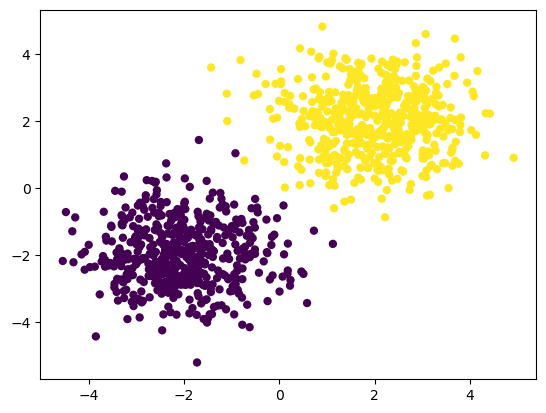

In [37]:
from tqdm import tqdm

# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [38]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [39]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [40]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

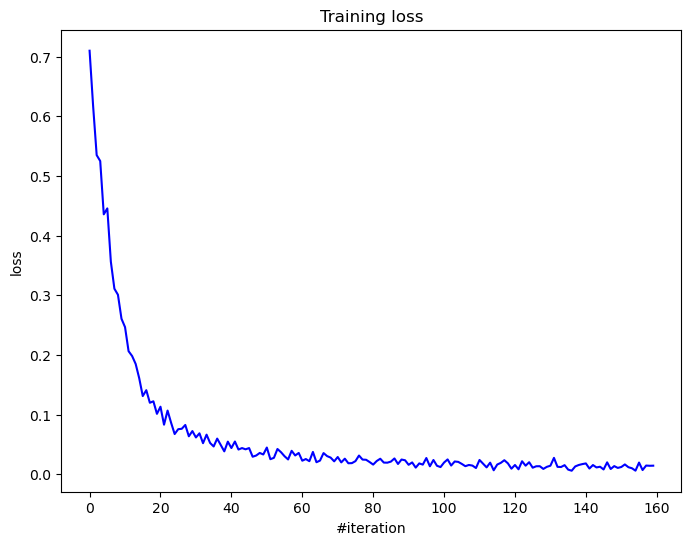

100%|██████████| 20/20 [00:07<00:00,  2.79it/s]

Current loss: 0.014589


In [41]:
loss_history = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in tqdm(get_batches((X, Y), batch_size)):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [46]:
from load_mnist_from_gz import load_dataset

In [47]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [48]:
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

One-hot encode the labels first.

In [49]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))

In [50]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

In [51]:
X_train.shape

(50000, 784)

In [52]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [53]:
# Optimizer params
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

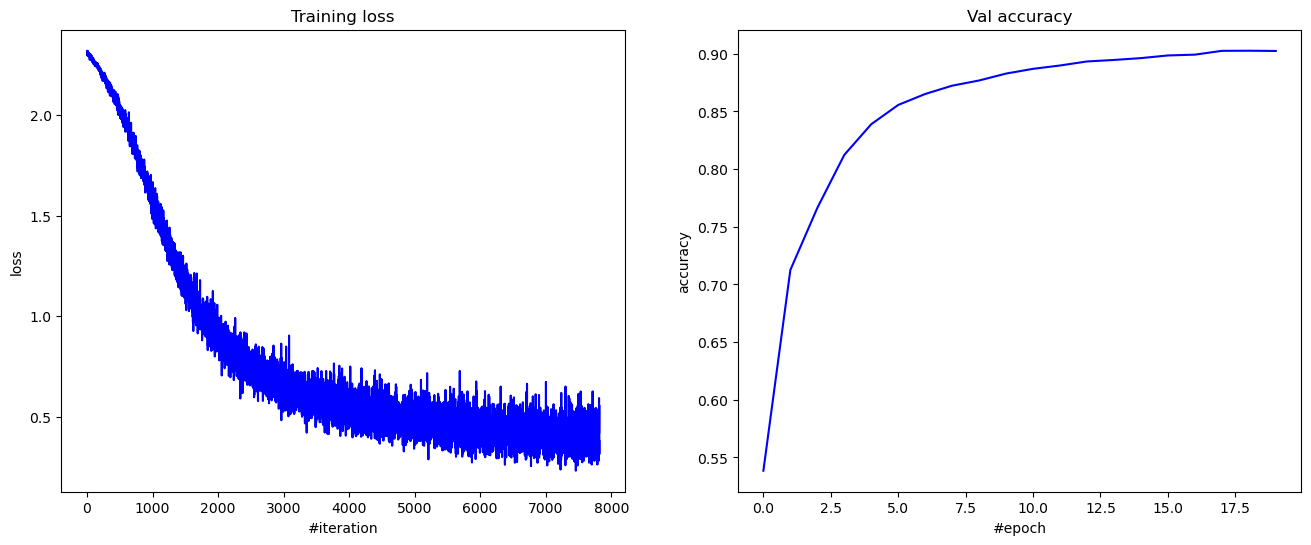

100%|██████████| 20/20 [00:56<00:00,  2.84s/it]

Current loss: 0.379330


In [106]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []

for i in tqdm(range(n_epoch)):
    net.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
    
    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)    
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    
    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   

### Test CNN

In [64]:
from load_mnist_from_gz import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [65]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse_output=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))
X_train.shape, X_val.shape, X_test.shape

((50000, 1, 28, 28), (10000, 1, 28, 28), (10000, 1, 28, 28))

In [69]:
net = Sequential()

net.add(Conv2d(1, 8, 3))
net.add(LeakyReLU())
net.add(MaxPool2d(2))

net.add(Conv2d(8, 4, 3))
net.add(LeakyReLU())
net.add(MaxPool2d(2))

net.add(Flatten())
net.add(Linear(7*7*4, 16))
net.add(LeakyReLU())

net.add(Linear(16, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Conv2d 1 -> 8
LeakyReLU
MaxPool2d, kern 2, stride 2
Conv2d 8 -> 4
LeakyReLU
MaxPool2d, kern 2, stride 2
Flatten
Linear 196 -> 16
LeakyReLU
Linear 16 -> 10
LogSoftMax



In [70]:
optimizer_config = {'learning_rate' : 3e-4, 
                    'beta1': 0.99, 
                    'beta2': 0.99, 
                    'epsilon': 1e-5}
optimizer_state = {}

n_epoch = 5
batch_size = 256

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

loss_history = []
accuracy_history = []

for i in tqdm(range(n_epoch), desc="Epochs"):
    net.train()
    
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size), desc="Batches", leave=False):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
    
    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
    
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)    
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    
    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)
